# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

# from google.colab import drive
# from os import chdir

# drive.mount('/content/drive')
# project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
# chdir(project_path)

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\n\nsetInterval(ConnectButton,60000);\n'

In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

D:\Gdrive\My Drive\Gproject\MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
dataset = pd.read_csv(load_name)

dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)
positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:      ", len(dataset.protein.unique()))
print("total number of samples:       ", len(dataset))
print("total number of positive sites:", len(positive))
print("total number of negative sites:", len(negative))

total number of proteins:       272
total number of samples:        41264
total number of positive sites: 521
total number of negative sites: 40743


## parameter settings

In [4]:
from src.Data import xy_variables, df_to_dummy, stratified_split, up_sampling
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 10

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'mlp_basic'

x_cts   = variables.x_cts_original
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

11 x_cts: ['ASA', 'Phi', 'Psi', 'Theta(i-1=>i+1)', 'Tau(i-2=>i+2)', 'HSE_alpha_up', 'HSE_alpha_down', 'P(C)', 'P(H)', 'P(E)', 'flexibility']
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (41264, 16)
dummy y shape: (41264, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: 'SEQ_S',
 12: 'SEQ_T',
 13: 'SS_C',
 14: 'SS_E',
 15: 'SS_H'}

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_size, save_path=save_path)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,24,4.048,0.661815,0.659861,0.653822,61.25,1.69,51.92,3.27
1,5,100,57,6.509,0.662758,0.659130,0.644206,63.35,1.78,51.92,3.45
2,5,100,37,4.489,0.659183,0.660111,0.658618,61.02,1.92,59.62,3.71
3,5,100,37,4.943,0.656893,0.653137,0.644792,62.28,1.64,49.04,3.17
4,5,100,114,10.876,0.661157,0.659473,0.655635,62.28,1.89,56.73,3.65
5,5,100,130,11.872,0.659496,0.659806,0.650087,63.69,1.80,51.92,3.48
6,5,100,111,10.405,0.658615,0.660087,0.654756,61.84,1.93,58.65,3.73
7,5,100,130,11.715,0.665477,0.660454,0.647025,62.90,1.98,58.65,3.83
8,5,100,31,4.559,0.667842,0.666006,0.659360,61.25,2.11,65.38,4.08
9,5,100,38,4.876,0.662912,0.663223,0.660629,61.55,1.85,56.73,3.59



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: -0.012024048096192367 1.124248496993988
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_1of10.h5


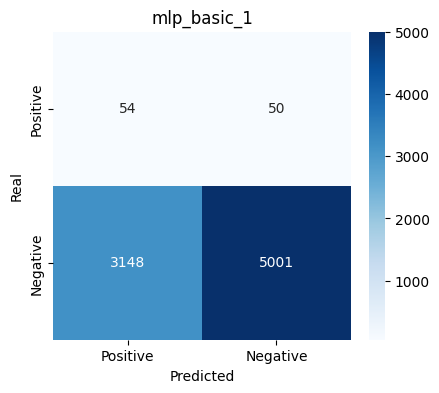

accuracy  : 61.25000000000001
precision : [99.01  1.69]
recall    : [61.37 51.92]
f1_score  : [75.77  3.27]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: -0.01669449081803005 1.0765027322404372
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_2of10.h5


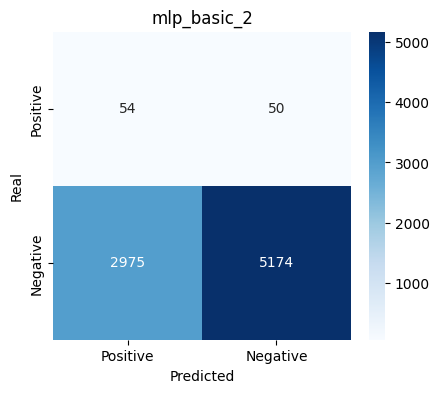

accuracy  : 63.349999999999994
precision : [99.04  1.78]
recall    : [63.49 51.92]
f1_score  : [77.38  3.45]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: 0.0 1.08719646799117
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_3of10.h5


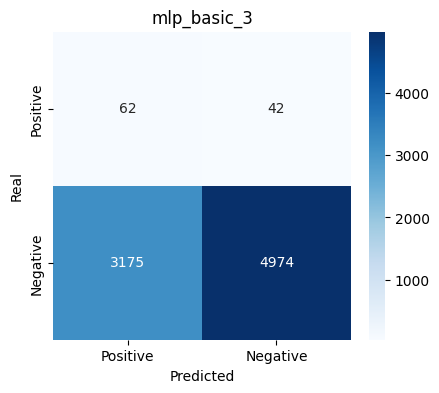

accuracy  : 61.019999999999996
precision : [99.16  1.92]
recall    : [61.04 59.62]
f1_score  : [75.56  3.71]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: -0.012024048096192367 1.124248496993988
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_4of10.h5


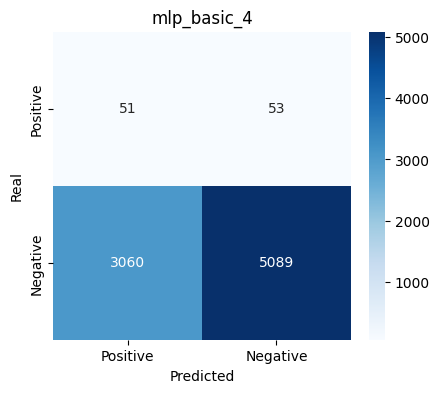

accuracy  : 62.28
precision : [98.97  1.64]
recall    : [62.45 49.04]
f1_score  : [76.58  3.17]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: 0.0 1.2722513089005236
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_5of10.h5


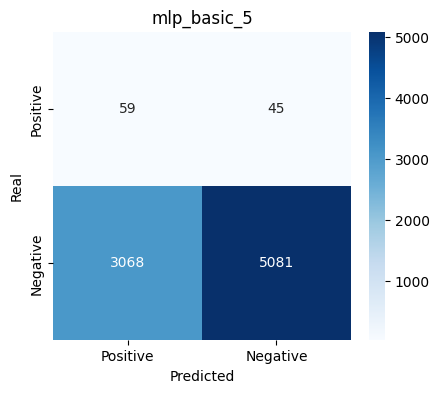

accuracy  : 62.28
precision : [99.12  1.89]
recall    : [62.35 56.73]
f1_score  : [76.55  3.65]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: 0.0 1.0133111480865227
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_6of10.h5


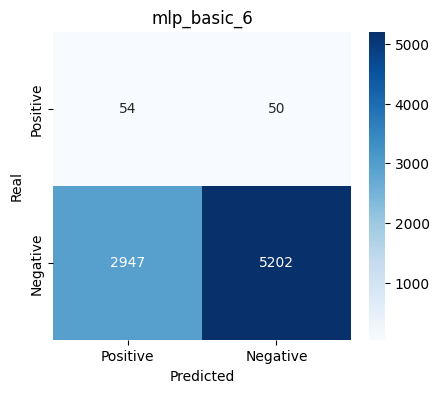

accuracy  : 63.690000000000005
precision : [99.05  1.8 ]
recall    : [63.84 51.92]
f1_score  : [77.64  3.48]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: -0.01669449081803005 1.1227722772277227
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_7of10.h5


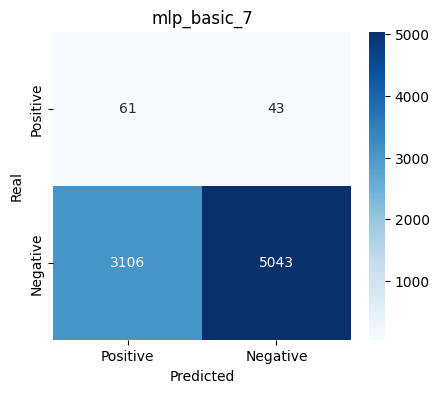

accuracy  : 61.839999999999996
precision : [99.15  1.93]
recall    : [61.88 58.65]
f1_score  : [76.21  3.73]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_8of10.h5


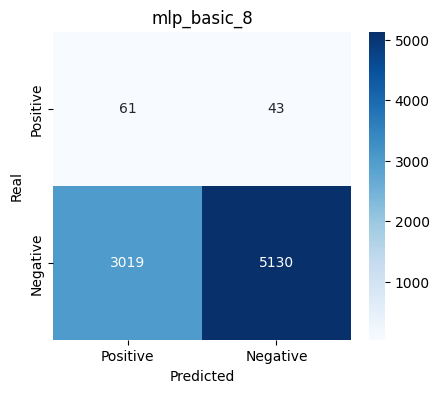

accuracy  : 62.9
precision : [99.17  1.98]
recall    : [62.95 58.65]
f1_score  : [77.02  3.83]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: -0.004077471967380227 1.0133111480865227
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_9of10.h5


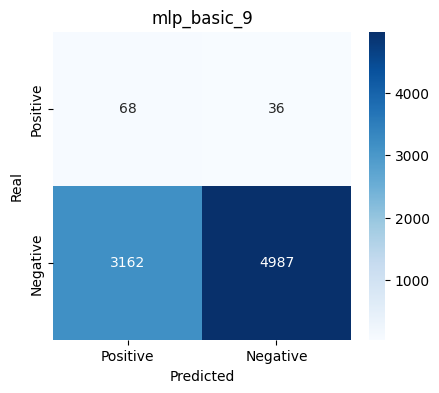

accuracy  : 61.25000000000001
precision : [99.28  2.11]
recall    : [61.2  65.38]
f1_score  : [75.72  4.08]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 16) (33011, 1)
check scale: 0.0 1.0

test: (8253, 16) (8253, 1)
check scale: 0.0 1.001002004008016
up-sampled train dataset: (65188, 16) (65188, 1)
MLP model has been restored from ./h5/mlp_basic_5_100_cv_10of10.h5


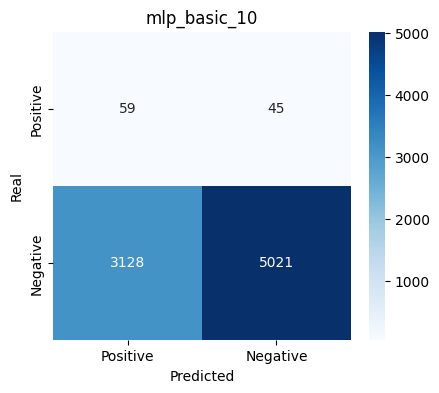

accuracy  : 61.550000000000004
precision : [99.11  1.85]
recall    : [61.61 56.73]
f1_score  : [75.99  3.59]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])